In [7]:
library(Seurat)
library(data.table) 
library(ggplot2)
library(ComplexUpset)
library(repr)

## Ridge plot from HTODemux result

In [1]:
# Load htodemux result from an rds object
htodemux_gx12 <- readRDS("../data/pipeline_output/gx12/htodemux.rds")

In [3]:
# Rename features
htodemux_gx12[["HTO"]]@counts@Dimnames[[1]] <- paste0("Hash45", 1:6)
dimnames(htodemux_gx12[["HTO"]]@data)[[1]] <- paste0("Hash45", 1:6)
htodemux_gx12 <- RenameIdents(htodemux_gx12, 'Hash453-TotalSeqA' = 'Hash453', 'Hash451-TotalSeqA' = 'Hash451', 'Hash452-TotalSeqA' = 'Hash452', 'Hash454-TotalSeqA' = 'Hash454',
    'Hash455-TotalSeqA' = 'Hash455', 'Hash456-TotalSeqA' = 'Hash456')

Picking joint bandwidth of 0.0666

Picking joint bandwidth of 0.0486

Picking joint bandwidth of 0.0383

Picking joint bandwidth of 0.0456

Picking joint bandwidth of 0.0165

Picking joint bandwidth of 0.047



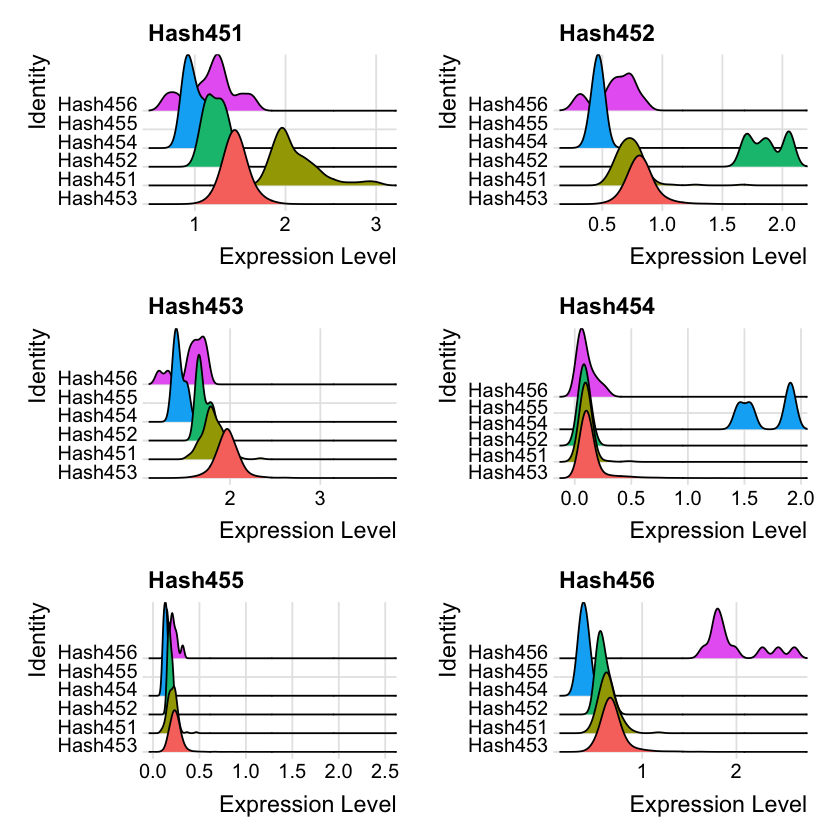

In [4]:
# Group cells based on the max HTO signal
Idents(htodemux_gx12) <- "HTO_maxID"
htodemux_gx12 <- RenameIdents(htodemux_gx12, 'Hash453-TotalSeqA' = 'Hash453', 'Hash451-TotalSeqA' = 'Hash451', 'Hash452-TotalSeqA' = 'Hash452', 'Hash454-TotalSeqA' = 'Hash454',
    'Hash455-TotalSeqA' = 'Hash455', 'Hash456-TotalSeqA' = 'Hash456')
RidgePlot(htodemux_gx12, assay = "HTO", features = paste0("Hash45", 1:6), ncol = 2) 
# ggsave("ridge_gx12.png", dpi = 300, height = 7, width = 9)

### Load hashing deconvolution results

In [6]:
# Load hashing deconvolution results
hash_gx12_classi <-fread("../data/pipeline_output/gx12/hash_classification_all.csv")

# Remove the trial ID
colnames(hash_gx12_classi) <- gsub("_1", "", colnames(hash_gx12_classi))

# Subset by only those cells detected by RNA
white_list_gx12 <- fread("../data/dataset/barcodes_gx12.tsv", header = F)$V1
hash_gx12_classi <- hash_gx12_classi[Barcode %in% white_list_gx12,]

# remove result of Solo
hash_gx12_classi <- hash_gx12_classi[, 1:6]

head(hash_gx12_classi)

Barcode,demuxem,hashedDrops,hashsolo,htodemux,multiseq
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAACCCAAGGTGTGAC-1,singlet,negative,singlet,singlet,singlet
AAACCCAGTGAGAGGG-1,singlet,NA,singlet,negative,doublet
AAACGAAAGAATCTAG-1,negative,negative,singlet,negative,negative
AAACGAACACATATGC-1,singlet,negative,singlet,negative,negative
AAACGAACACGACTAT-1,singlet,negative,singlet,singlet,singlet
AAACGAACATCAGCAT-1,negative,negative,singlet,singlet,negative


## Upset plot for droplet classification of hashing deconvolution methods
### Turn the assignment into a binary matrix

In [8]:
# table in a long format
hash_gx12_classi_new <- melt(hash_gx12_classi, id.vars=1)
hash_gx12_classi_new <- na.omit(hash_gx12_classi_new)
head(hash_gx12_classi_new)

Barcode,variable,value
<chr>,<fct>,<chr>
AAACCCAAGGTGTGAC-1,demuxem,singlet
AAACCCAGTGAGAGGG-1,demuxem,singlet
AAACGAAAGAATCTAG-1,demuxem,negative
AAACGAACACATATGC-1,demuxem,singlet
AAACGAACACGACTAT-1,demuxem,singlet
AAACGAACATCAGCAT-1,demuxem,negative


In [9]:
# Subset to singlets
hash_gx12_classi_new_singlet <- hash_gx12_classi_new[hash_gx12_classi_new$value=='singlet',]
hash_gx12_classi_new_singlet <- hash_gx12_classi_new_singlet[, -3]

# table in a wide format
hash_gx12_classi_new_singlet <- dcast(hash_gx12_classi_new_singlet, Barcode~variable)
hash_gx12_classi_new_singlet <- as.data.frame(lapply(hash_gx12_classi_new_singlet[, -1], as.numeric))

# turn into a binary matrix
hash_gx12_classi_new_singlet[!is.na(hash_gx12_classi_new_singlet)] <- 1
hash_gx12_classi_new_singlet[is.na(hash_gx12_classi_new_singlet)] <- 0
head(hash_gx12_classi_new_singlet)

Using 'variable' as value column. Use 'value.var' to override



,demuxem,hashedDrops,hashsolo,htodemux,multiseq
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,1,1,1
2,1,0,1,0,0
3,0,0,1,0,0
4,1,0,1,0,0
5,1,0,1,1,1
6,0,0,1,1,0


### Make the upset plot

Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.
ℹ The deprecated feature was likely used in the ComplexUpset package.
  Please report the issue at
  <https://github.com/krassowski/complex-upset/issues>.”


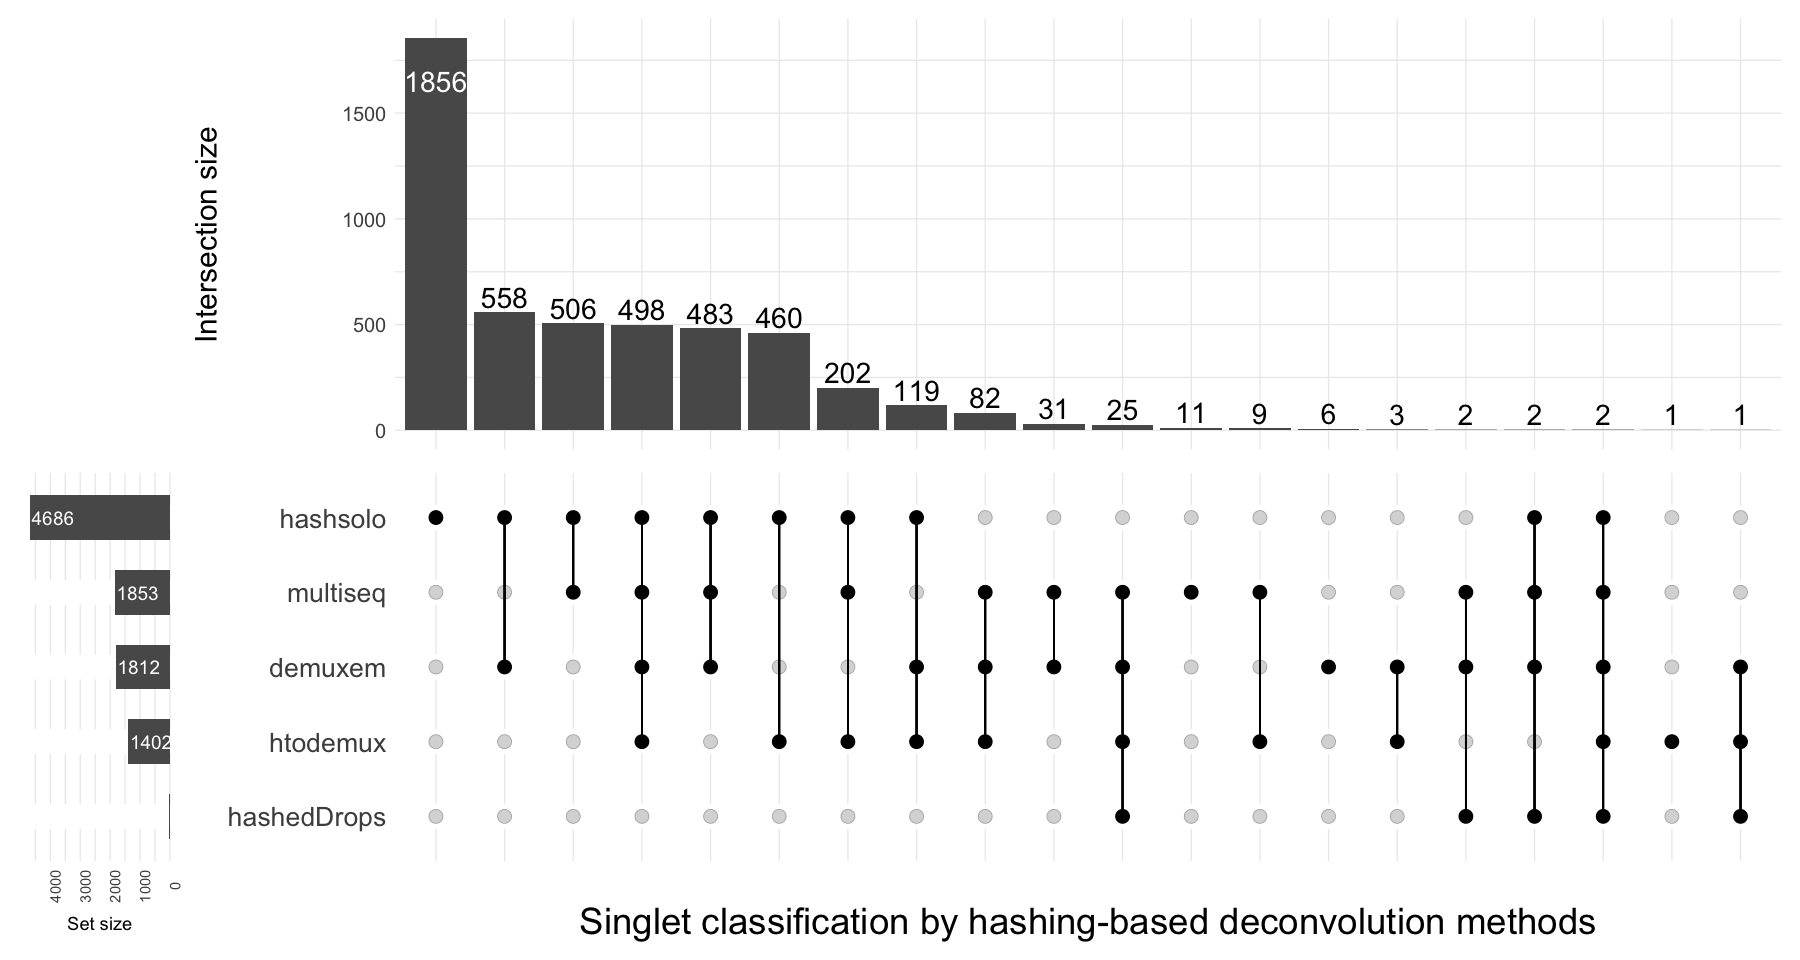

In [10]:
# Change plot size to 15 x 8
options(repr.plot.width=15, repr.plot.height=8)

# upset plot 
ComplexUpset::upset(hash_gx12_classi_new_singlet, colnames(hash_gx12_classi_new_singlet), width_ratio = 0.1, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1,
                    name="Singlet classification by hashing-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count..), hjust = -0.05, stat = 'count', color = 'white', size=4) +
                               theme(axis.text.x = element_text(angle = 90))),# set size
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=6))+
                                        theme(axis.text=element_text(size=12), axis.title=element_text(size=18))), # intersection size
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=16), #method
                                                                                text=element_text(size=22)))))# title

# ggsave("S2-upset-hash-singlet-gx12.png", width= 15, height=5, dpi=300)

In [11]:
# Subset to doublets
hash_gx12_classi_new_doublet <- hash_gx12_classi_new[hash_gx12_classi_new$value=='doublet',]
hash_gx12_classi_new_doublet <- hash_gx12_classi_new_doublet[, -3]

# table in a wide format
hash_gx12_classi_new_doublet <- dcast(hash_gx12_classi_new_doublet, Barcode~variable)
hash_gx12_classi_new_doublet <- as.data.frame(lapply(hash_gx12_classi_new_doublet[, -1], as.numeric))

# turn into a binary matrix
hash_gx12_classi_new_doublet[!is.na(hash_gx12_classi_new_doublet)] <- 1
hash_gx12_classi_new_doublet[is.na(hash_gx12_classi_new_doublet)] <- 0
head(hash_gx12_classi_new_doublet)

Using 'variable' as value column. Use 'value.var' to override



,demuxem,hashsolo,htodemux,multiseq
,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,1
2,0,1,1,1
3,1,0,0,0
4,0,0,1,0
5,1,0,0,0
6,1,0,0,0


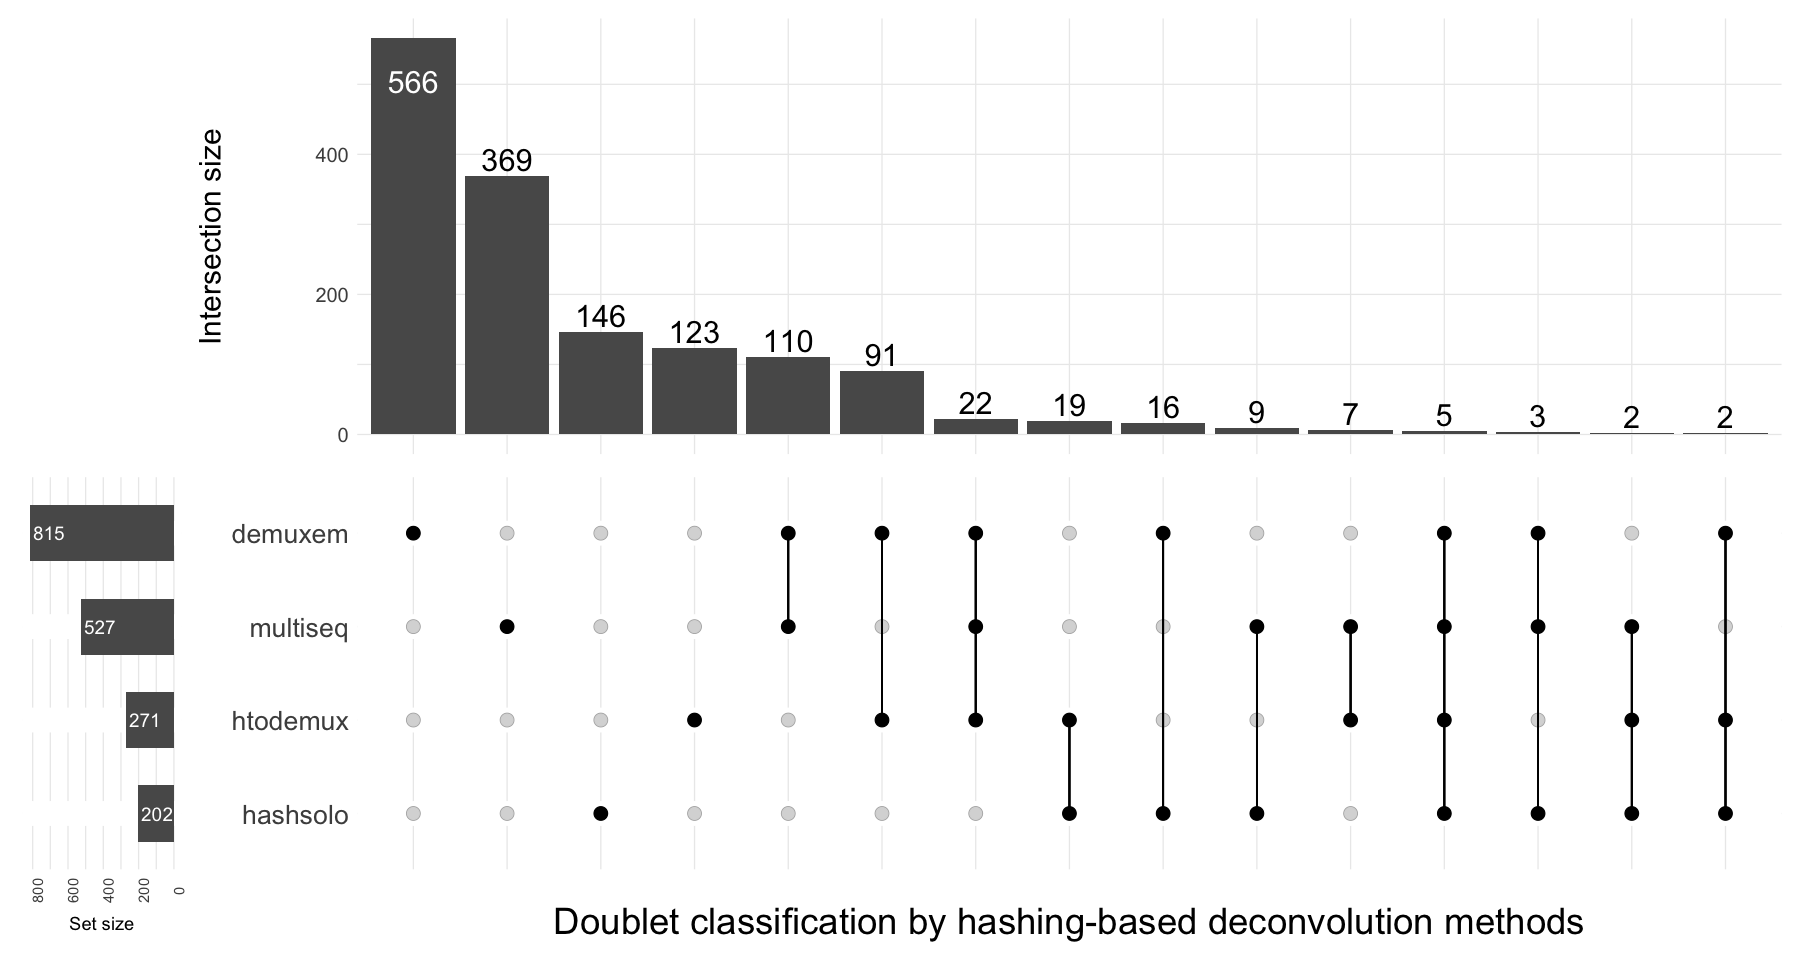

In [12]:
ComplexUpset::upset(hash_gx12_classi_new_doublet, colnames(hash_gx12_classi_new_doublet), width_ratio = 0.1, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Doublet classification by hashing-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count..), hjust = -0.1, stat = 'count', color = 'white', size=4) +
                               theme(axis.text.x = element_text(angle = 90))),# set size
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=6.5))+
                                        theme(axis.text=element_text(size=12), axis.title=element_text(size=18))), # intersection size
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=16), #method
                                                                                text=element_text(size=22)))))# title
# ggsave("S3-upset-hash-doublet-gx12.png", width= 15, height=5, dpi=300)